In the name of Allah

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv('./../../SentiMovie/data/normalized_data.csv')
data

,rotten_tomatoes_link,movie_title,critics_consensus,tomatometer_rating,tomatometer_status,audience_status,audience_rating,audience_count,review_type,review_score,review_content
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,49.0,Rotten,Spilled,53.0,254421.0,Fresh,NaN,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,49.0,Rotten,Spilled,53.0,254421.0,Fresh,NaN,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,49.0,Rotten,Spilled,53.0,254421.0,Fresh,NaN,With a top-notch cast and dazzling special eff...
3,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,49.0,Rotten,Spilled,53.0,254421.0,Fresh,7.000000,Whether audiences will get behind The Lightnin...
4,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,49.0,Rotten,Spilled,53.0,254421.0,Rotten,NaN,What's really lacking in The Lightning Thief i...
...,...,...,...,...,...,...,...,...,...,...,...
949176,m/zulu,Zulu,Zulu patiently establishes a cast of colorful ...,96.0,Fresh,Upright,91.0,30193.0,Fresh,NaN,A rousing reconstruction of the 1879 Battle of...
949177,m/zulu_dawn,Zulu Dawn,NaN,50.0,Rotten,Upright,62.0,4469.0,Fresh,7.000000,"Seen today, it's not only a startling indictme..."
949178,m/zulu_dawn,Zulu Dawn,NaN,50.0,Rotten,Upright,62.0,4469.0,Fresh,8.333333,A rousing visual spectacle that's a prequel of...
949179,m/zulu_dawn,Zulu Dawn,NaN,50.0,Rotten,Upright,62.0,4469.0,Rotten,7.000000,"A simple two-act story: Prelude to war, and th..."


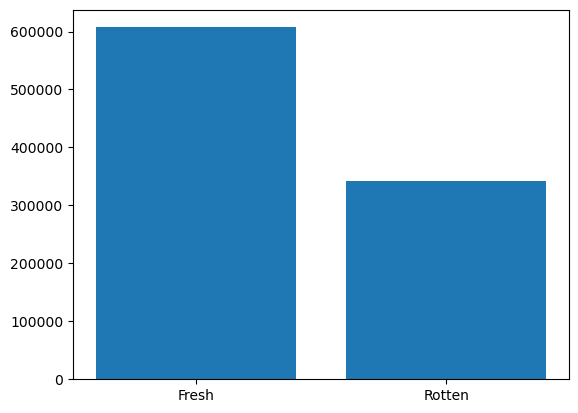

In [ ]:
class imbalance_handling:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    
    def Upsample_with_double_trans(self):
        
        
        
        return x, y

## Split for first task

In [15]:
X_rem, X_test, y_rem, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=42, stratify=y_data)
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.1, random_state=42, stratify=y_rem)
print(f"Train: {len(y_train)} ({(len(y_train)/len(y_data))*100:.0f}%)")
print(f"Val: {len(y_val)} ({(len(y_val)/len(y_data))*100:.0f}%)")
print(f"Test: {len(y_test)} ({(len(y_test)/len(y_data))*100:.0f}%)")

Train: 768835 (81%)
Val: 85427 (9%)
Test: 94919 (10%)
